In [1]:
from imutils import face_utils
import imutils
import time
import dlib
import cv2
import logging
import json
logging.disable(logging.INFO)

import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import numpy as np
import pickle

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Data Importing

In [2]:
# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
# Create prelim df with filename and target emotion class (mood)
data_path = 'dataset/'
dataset1, dataset2 = 'ck', 'mux'
model_path = 'trained_models/'
moods = [k for k in os.listdir(data_path + dataset1 + '/') if '.' not in k]

# load vectors & coords df
def getVectorsData(dataset):
    df = None
    if os.path.isfile(data_path + dataset + '/df_vector_coods.csv'):
        df = pd.read_csv(data_path + dataset + '/df_vector_coods.csv', index_col='filename')
        df['vectors'] = df['vectors'].apply(json.loads)
        df['coords'] = df['coords'].apply(json.loads)

        indexNames = df[(df.vectors.str.len().eq(0)) | (df.coords.str.len().eq(0))].index 
        indexNames = list(indexNames)
        for index,row in df.iterrows():
            if len(row['vectors']) != 68:
                indexNames.append(index)
        print('Deleted',len(indexNames),'rows.')
        df.drop(indexNames , inplace=True)
    else:
        print('[%s] Vectors & coords data does not exist.' % dataset)
    return df

df_ck = getVectorsData(dataset1)
df_mux = getVectorsData(dataset2)
    
display(df_ck.sample(10))
display(df_mux.sample(10))
    
# load graylevels Numpy arrays
def getGrayLevelsData(dataset):
    cropped_dataseta, cropped_target = None, None
    if os.path.isfile(data_path + dataset + '/graylevels_data.npy'):
        with open(data_path + dataset + '/graylevels_data.npy', 'rb') as f:
            cropped_dataset = np.load(f)
            cropped_target = np.load(f)
    else:
        print('Graylevels data does not exist.')
    return cropped_dataset, cropped_target

ck_cropped_dataset, ck_cropped_target = getGrayLevelsData(dataset1)
mux_cropped_dataset, mux_cropped_target = getGrayLevelsData(dataset2)

dim = 50

Deleted 0 rows.
Deleted 2377 rows.


,mood,vectors,coords
filename,,,
S054_004_00000001.png,neutral,"[-2.54087168201744, -2.4563195349088525, -2.43...","[-0.8468226603321466, -0.44034778337271624, -0..."
S108_004_00000001.png,neutral,"[-2.7170312732254356, -2.6527084283889866, 2.6...","[-0.9112194973032037, -0.4119211426165168, -0...."
S069_004_00000001.png,neutral,"[-2.652601457207897, -2.624392856509746, 2.551...","[-0.8919184845718194, -0.35908406521722597, -0..."
S138_006_00000001.png,neutral,"[-2.6747518970181074, -2.6481163435027093, 2.5...","[-0.8995994542229383, -0.3547716157498912, -0...."
S101_003_00000001.png,neutral,"[-2.538159176151531, -2.3826321877310392, -2.3...","[-0.8233920666857287, -0.5674729108239481, -0...."
S111_006_00000001.png,neutral,"[-2.715217001128719, -2.6770363215745223, 2.54...","[-0.9136093699852554, -0.3125505739423242, -0...."
S137_005_00000001.png,neutral,"[-2.6816436076873886, -2.655792054656335, 2.67...","[-0.8978535309362293, -0.4252990409697928, -0...."
S126_001_00000001.png,neutral,"[-2.396715303577789, -2.292218703363398, -2.29...","[-0.7928137334583073, -0.4578220150956422, -0...."
S119_003_00000001.png,neutral,"[-2.8318897090473367, -2.806118278509325, 2.65...","[-0.9524241471993242, -0.30477572710378376, -0..."


,mood,vectors,coords
filename,,,
Saddam_Hussein_0001.jpg,happiness,"[-1.5904540370224522, -1.6899271908849305, -1....","[-0.5007268906852157, -0.4117087767856218, -0...."
Barry_Diller_0001.jpg,neutral,"[-2.84098104845101, 2.7433793717638135, 2.5812...","[-0.9247695540727455, -0.07330490367649813, -0..."
Patti_Labelle_0001.jpg,happiness,"[-2.724818999975525, -2.698534802964256, 2.730...","[-0.9143997621846554, -0.4048123947171651, -0...."
Oscar_De_La_Hoya_0006.jpg,neutral,"[-2.0764442766782873, -2.031844097840041, 2.02...","[-0.6930431046096218, -0.35120427598460563, -0..."
Tommy_Robredo_0002.jpg,anger,"[-2.4908991548254686, -2.4640524605995706, 2.3...","[-0.8367529685029498, -0.355483287272495, -0.8..."
Jennifer_Aniston_0021.jpg,surprise,"[-2.737878708877702, -2.7358901324975844, 2.61...","[-0.9210758010873973, -0.3531585973081212, -0...."
Recep_Tayyip_Erdogan_0018.jpg,anger,"[-2.846776946600108, -2.8850214968316448, 2.74...","[-0.9568557073945356, -0.29056351324022545, -0..."
James_Young_0001.jpg,neutral,"[-1.501353872604438, -1.50776783645695, 1.6002...","[-0.485071250072666, -0.3439596136878904, -0.5..."
Scott_Dalton_0001.jpg,happiness,"[-2.631605595903346, -2.716072366191407, 2.865...","[-0.8784294458663557, -0.44426316802436383, -0..."


In [4]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

# Model training

In [4]:
from keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score

## Functions
The following functions are used for building, training and evaluation of CNN models for inputs of vectors, coordinates and image graylevels.

In [5]:
num_classes = len(moods)

def build_cnn(model_name, model_num, input_shape):
    print('Building model...', end=' ')
    model = Sequential()

    # CS3237 model for coords & vectors
    if model_num == 1:
        model.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(Conv1D(128, kernel_size=5, activation='relu'))
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.1))

    # Ansamma's model
    if model_num == 2:
        model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(512, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(512, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.1))

    # CS3237 model for image graylevels
    if model_num == 3:
        model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
#         model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
#         model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax'))

    print('Model built.')
    
    return model

In [6]:
def train_cnn(model, data, epochs, model_name, verbose=False, plots=True):
    
    x_train, y_train, x_val, y_val, x_test, y_test = data[0], data[1], data[2], data[3], data[4], data[5]
#     opt = Adam(learning_rate = 0.0001)
    opt = SGD(learning_rate=0.01, momentum=0.7)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    savemodel = ModelCheckpoint(model_name)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)

    print("Starting training...")
    start = time.time()
    history = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_val,y_val), shuffle=True,
              epochs=epochs, verbose=verbose,
              callbacks=[savemodel,stopmodel])
    end = time.time()
    tt = end - start
    print("Done (%d epochs). Time taken: %dm%ds." % (len(history.history['loss']), tt//60, tt%60))
    
    if plots:
        # plot loss
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='validation')
        ymax = max([1, max(history.history['loss'])+0.05, max(history.history['val_loss'])+0.05])
        plt.ylim(0,ymax)
        plt.legend()
        plt.show()

        # plot accuracy
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='validation')
        plt.ylim(0,1)
        plt.legend()
        plt.show()

In [7]:
def evaluate_cnn(model_name, data, tag=""):
    tag += " " if tag else ""
    model = load_model(model_name)
    x_train, y_train, x_val, y_val, x_test, y_test = data[0], data[1], data[2], data[3], data[4], data[5]
    loss_tr, acc_tr = model.evaluate(x=x_train, y=y_train, verbose=False)
    loss_val, acc_val = model.evaluate(x=x_val, y=y_val, verbose=False)
    loss_ts, acc_ts = model.evaluate(x=x_test, y=y_test, verbose=False)
    print(tag + 'Train accuracy: %.4f, loss: %.4f' % (acc_tr, loss_tr))
    print(tag + 'Validation accuracy: %.4f, loss: %.4f' % (acc_val, loss_val))
    print(tag + 'Test accuracy: %4.3f, loss: %4.3f' % (acc_ts, loss_ts))
    return (acc_tr, acc_val, acc_ts)

## CNN
CNN models trained on vectors and coordinates.

### CNN Datasets
Separate datasets ```cnn_vectors_only_data``` and ```cnn_vectors_coords_data``` for dataset with vectors only and dataset with both vectors and coordinates.

In [12]:
# One hot encoding for emotion
cnn_ck_data = pd.get_dummies(df_ck.mood).join(df_ck.loc[:,['vectors','coords']])
emotion_classes = cnn_ck_data.columns[:len(moods)]
print('One hot encoded:')
display(cnn_ck_data.sample(5))

One hot encoded:


,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,vectors,coords
filename,,,,,,,,,,
S102_007_00000001.png,0,0,0,0,0,1,0,0,"[-2.4720940863260075, -2.4308317749642026, 2.3...","[-0.8307132780604194, -0.34716375799539917, -0..."
S080_001_00000001.png,0,0,0,0,0,1,0,0,"[-2.4673875410998827, -2.364653209820792, 2.26...","[-0.825748884391037, -0.39542904322951067, -0...."
S115_003_00000001.png,0,0,0,0,0,1,0,0,"[-2.702372788086423, -2.605379179468779, 2.474...","[-0.9089509959816077, -0.3562105254522517, -0...."
S101_002_00000019.png,0,0,0,0,0,0,0,1,"[-2.5229569978804656, -2.3838883648010816, -2....","[-0.8241260656208734, -0.5384290295389706, -0...."
S077_006_00000001.png,0,0,0,0,0,1,0,0,"[-2.6189333341358942, -2.54792553075053, 2.518...","[-0.876512961547363, -0.4192018511748258, -0.8..."


In [8]:
# One hot encoding for emotion
cnn_mux_data = pd.get_dummies(df_mux.mood).join(df_mux.loc[:,['vectors','coords']])
emotion_classes = cnn_mux_data.columns[:len(moods)]
print('One hot encoded:')
display(cnn_mux_data.sample(5))

One hot encoded:


,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,vectors,coords
filename,,,,,,,,,,
S042_001_00000019.png,0,0,0,0,0,0,0,1,"[-2.131001101764436, -2.0870016009578545, 2.13...","[-0.7012395673805306, -0.4285352911769909, -0...."
Shinzo_Abe_0001.jpg,0,0,0,0,0,1,0,0,"[-2.4735922542247946, 2.3995816766210654, 2.10...","[-0.826196252294895, -0.18425959583555213, -0...."
Frances_Fisher_0001.jpg,0,0,0,0,1,0,0,0,"[-2.475252101229417, -2.4690047099334023, 2.26...","[-0.8324735739947893, -0.26619794517275236, -0..."
Vladimir_Putin_0043.jpg,0,0,0,0,0,0,1,0,"[-2.5320590574749313, -2.426804306900496, -2.4...","[-0.8199151162947789, -0.5724851107857035, -0...."
Colin_Farrell_0008.jpg,0,0,0,0,1,0,0,0,"[-2.2914014071682103, -2.1736378555738995, -2....","[-0.7597217761636013, -0.4264244808144085, -0...."


In [81]:
# Dataset for vectors only
# split into train, val and test
x = np.array([k for k in cnn_ck_data['vectors'].values])
y = cnn_ck_data.iloc[:,:8].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

cnn_vectors_only_data = [x_train, y_train, x_val, y_val, x_test, y_test]

print('(Vectors Only) Train X shape:', x_train.shape)
print('(Vectors Only) Train Y shape:', y_train.shape)

(Vectors Only) Train X shape: (588, 68, 1)
(Vectors Only) Train Y shape: (588, 8)


In [83]:
# Dataset for vectors & coords
# split into train, val and test
x = np.c_[np.array([k for k in cnn_mux_data['vectors'].values]), np.array([k for k in cnn_mux_data['coords'].values])]
y = cnn_mux_data.iloc[:,:8].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

cnn_vectors_coords_data = [x_train, y_train, x_val, y_val, x_test, y_test]

print('(Vectors & Coords) Train X shape:', x_train.shape)
print('(Vectors & Coords) Train Y shape:', y_train.shape)

(Vectors & Coords) Train X shape: (8581, 204, 1)
(Vectors & Coords) Train Y shape: (8581, 8)


### CNN Models

In [ ]:
# CNN1: CS3237 model (Vectors only)
MODEL_NAME = model_path + 'emotion-cnn4.hd5'
model = build_cnn(MODEL_NAME, 1, (cnn_vectors_only_data[0].shape[1],1))
train_cnn(model, cnn_vectors_only_data, 200, MODEL_NAME)
cnn1_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_only_data)

In [ ]:
# CNN2: Ansamma's model (Vectors only)
MODEL_NAME = model_path + 'emotion-cnn5.hd5'
model = build_cnn(MODEL_NAME, 2, (68,1))
train_cnn(model, cnn_vectors_only_data, 200, MODEL_NAME)
cnn2_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_only_data)

In [ ]:
# CNN3: CS3237 model (Vectors & coords)
MODEL_NAME = model_path + 'emotion-cnn6.hd5'
model = build_cnn(MODEL_NAME, 1, (cnn_vectors_coords_data[0].shape[1],1))
train_cnn(model, cnn_vectors_coords_data, 200, MODEL_NAME)
cnn3_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_coords_data)

In [49]:
cnn1_acc = evaluate_cnn(model_path + 'emotion-cnn4.hd5', cnn_vectors_only_data, 'CNN1')
print()
cnn2_acc = evaluate_cnn(model_path + 'emotion-cnn5.hd5', cnn_vectors_only_data, 'CNN2')
print()
cnn3_acc = evaluate_cnn(model_path + 'emotion-cnn6.hd5', cnn_vectors_coords_data, 'CNN3')
print()

CNN1 Train accuracy: 0.8482, loss: 0.4508
CNN1 Validation accuracy: 0.8285, loss: 0.5150
CNN1 Test accuracy: 0.845, loss: 0.473

CNN2 Train accuracy: 0.8484, loss: 0.4543
CNN2 Validation accuracy: 0.8257, loss: 0.5461
CNN2 Test accuracy: 0.834, loss: 0.518

CNN3 Train accuracy: 0.8656, loss: 0.3950
CNN3 Validation accuracy: 0.8374, loss: 0.4910
CNN3 Test accuracy: 0.852, loss: 0.449



## SVM

### SVM Datasets
Separate datasets ```svm_vectors_only_data``` and ```svm_vectors_coords_data``` for dataset with vectors only and dataset with both vectors and coordinates.

In [8]:
# Label encoding for SVM
svm_data = df.copy()
le = LabelEncoder()
svm_data['mood'] = le.fit_transform(svm_data['mood'].values)
svm_classes = list(le.inverse_transform(np.arange(0,8)))
print('Label encoded:')
display(svm_data.sample(5))

Label encoded:


,mood,vectors,coords
filename,,,
James_Wallack_0001.jpg,5,"[-2.7391791769767284, -2.719027444868351, 2.69...","[-0.9201184603247637, -0.3916401651638738, -0...."
Dileep_10.jpg,5,"[-2.4758691750571793, -2.5407023948366074, 2.4...","[-0.8318755209546262, -0.24598469705647552, -0..."
Win_Aung_0004.jpg,5,"[-2.0368961360354154, -1.9992928495924474, -2....","[-0.6630748816121287, -0.4452765628344222, -0...."
Norah_Jones_0003.jpg,4,"[-2.6982374617301432, -2.6727369468145694, -2....","[-0.9033174647441011, -0.4289726773213996, -0...."
Ray_Nagin_0002.jpg,4,"[-2.800300613065477, -2.7557358139174015, 2.63...","[-0.942322999908383, -0.334704890677841, -0.90..."


In [9]:
# Dataset for vectors only
# split into train, val and test
x = np.array([k for k in svm_data['vectors'].values])
y = svm_data['mood'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

svm_vectors_only_data = [x_train, y_train, x_test, y_test]

print('(Vectors only) Train X shape:', x_train.shape)
print('(Vectors only) Train Y shape:', y_train.shape)

(Vectors only) Train X shape: (10727, 68)
(Vectors only) Train Y shape: (10727,)


In [10]:
# Dataset for vectors & coords
# split into train, val and test
x = np.c_[np.array([k for k in svm_data['vectors'].values]), np.array([k for k in svm_data['coords'].values])]
y = svm_data['mood'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

svm_vectors_coords_data = [x_train, y_train, x_test, y_test]

print('(Vectors & Coords) Train X shape:', x_train.shape)
print('(Vectors & Coords) Train Y shape:', y_train.shape)

(Vectors & Coords) Train X shape: (10727, 204)
(Vectors & Coords) Train Y shape: (10727,)


### SVM Functions
Functions for building, training and evaluation of SVM models.

In [21]:
def train_svm(x_train, y_train):
#     params = {'C':[10e-3, 10e-2, 0.1, 1, 10], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'decision_function_shape':('ovr', 'ovo')}
    params = {'C':[10e-2, 0.1, 1]}
    svm_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('svm', GridSearchCV(svm.SVC(max_iter=100000, probability=True, kernel='linear', decision_function_shape='ovr'), params)), ])
#     svm_pipe = Pipeline([('scaler', StandardScaler()), 
#                        ('svm', svm.SVC(max_iter=100000, probability=True, kernel='linear', decision_function_shape='ovr'), params), ])
    start = time.time()
    svm_pipe.fit(x_train, y_train)
    end = time.time()
    print('SVM model trained. Time taken: %.3fs.' % (end-start))
    print('Best params:', svm_pipe['svm'].best_params_)
    
    return svm_pipe

In [22]:
def evaluate_svm(svm, data, name):
    if isinstance(svm, str):
        svm = pickle.load(open(model_path+svm, 'rb'))
    
    x_train, y_train, x_test, y_test = data[0], data[1], data[2], data[3]
    
    # Prediction
    y_train_pred = svm.predict(x_train)
    y_test_pred = svm.predict(x_test)

    # Evaluation
    acc_tr = accuracy_score(y_train, y_train_pred)
    acc_ts = accuracy_score(y_test, y_test_pred)
    print('%s Train accuracy: %.4f' % (name, acc_tr))
    print('%s Test accuracy: %.4f' % (name, acc_ts))
    
    return (acc_tr, None, acc_ts)

### SVM1: Vectors only

In [23]:
svm1 = train_svm(svm_vectors_only_data[0], svm_vectors_only_data[1])

C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre

SVM model trained. Time taken: 178.410s.
Best params: {'C': 1}


C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [24]:
svm1_acc = evaluate_svm(svm1, svm_vectors_only_data, 'SVM1')

SVM1 Train accuracy: 0.8491
SVM1 Test accuracy: 0.8606


### SVM2: Vectors & Coords

In [25]:
svm2 = train_svm(svm_vectors_coords_data[0], svm_vectors_coords_data[1])

C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre

SVM model trained. Time taken: 456.691s.
Best params: {'C': 1}


C:\Users\rage8\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [26]:
svm2_acc = evaluate_svm(svm2, svm_vectors_coords_data, 'SVM2')

SVM2 Train accuracy: 0.8714
SVM2 Test accuracy: 0.8639


In [27]:
# Save models
pickle.dump(svm1, open(model_path + 'emotion-svm3', 'wb'))
pickle.dump(svm2, open(model_path + 'emotion-svm4', 'wb'))

In [43]:
svm1_acc = evaluate_svm('emotion-svm3', svm_vectors_only_data, 'SVM1')
print()
svm2_acc = evaluate_svm('emotion-svm4', svm_vectors_coords_data, 'SVM2')

SVM1 Train accuracy: 0.8491
SVM1 Test accuracy: 0.8606

SVM2 Train accuracy: 0.8714
SVM2 Test accuracy: 0.8639


## Cropped Images
Model input is pixel graylevels instead of vectors/coordinates. CNN is used.

In [9]:
def generateGraylevelDataset(cropped_dataset, cropped_target):
    cropped_target = LabelEncoder().fit_transform(cropped_target)
    
    # train-test-val split
    x_train, x_test, y_train, y_test = train_test_split(cropped_dataset, cropped_target, test_size=0.20, random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

    # reshape for CNN (samples, w, h, c)
    x_train = x_train.reshape(x_train.shape[0], dim, dim, 1)
    x_val = x_val.reshape(x_val.shape[0], dim, dim, 1)
    x_test = x_test.reshape(x_test.shape[0], dim, dim, 1)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_test = x_test.astype('float32')

    # normalization
    x_train /= 255.0
    x_val /= 255.0
    x_test /= 255.0

    # one-hot encoding
    num_classes = len(moods)
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    print('Train X shape:', x_train.shape)
    print('Train Y shape:', y_train.shape)
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

Train X shape: (588, 50, 50, 1)
Train Y shape: (588, 8)
Building model... Model built.
Starting training...
Done (50 epochs). Time taken: 0m59s.


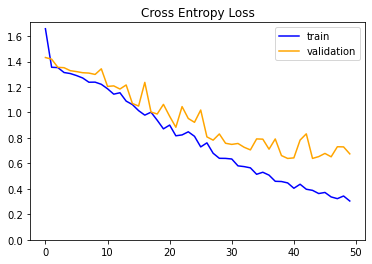

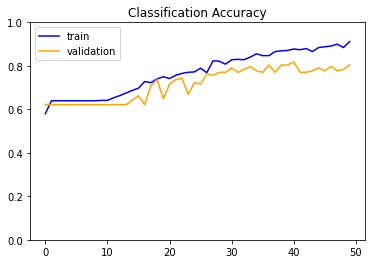

Train accuracy: 0.9286, loss: 0.2343
Validation accuracy: 0.8041, loss: 0.6747
Test accuracy: 0.832, loss: 0.699


In [13]:
MODEL_NAME = model_path + 'emotion-cnnA.hd5'
ck_graylevels_data = generateGraylevelDataset(ck_cropped_dataset, ck_cropped_target)
model = build_cnn(MODEL_NAME, 3, (dim, dim, 1))
train_cnn(model, ck_graylevels_data, 100, MODEL_NAME, verbose=False)
cnnA_acc = evaluate_cnn(MODEL_NAME, ck_graylevels_data)

Train X shape: (8396, 50, 50, 1)
Train Y shape: (8396, 8)
Building model... Model built.
Starting training...
Done (29 epochs). Time taken: 1m45s.


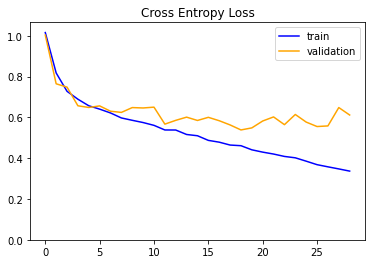

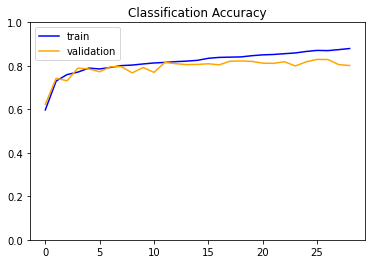

NameError: name 'graylevels_data' is not defined

In [10]:
MODEL_NAME = model_path + 'emotion-cnnB.hd5'
mux_graylevels_data = generateGraylevelDataset(mux_cropped_dataset, mux_cropped_target)
model = build_cnn(MODEL_NAME, 3, (dim, dim, 1))
train_cnn(model, mux_graylevels_data, 100, MODEL_NAME, verbose=False)
cnnB_acc = evaluate_cnn(MODEL_NAME, mux_graylevels_data)

# Comparison
This section is for comparison between models. I'll compare their accuracies, then I'll test the models on random images.

## Metrics

In [50]:
accuracies = [cnn1_acc, cnn2_acc, cnn3_acc, svm1_acc, svm2_acc, cnnA_acc]
evaluate_dict = {
    'Model': ['CNN1','CNN2','CNN3','SVM1','SVM2','CNNA'],
    'Inputs': ['Vectors only','Vectors only','Vectors & coords','Vectors only','Vectors & coords','Pixel graylevels'],
    'Train acc': [k[0] for k in accuracies],
    'Val acc': [k[1] for k in accuracies],
    'Test acc': [k[2] for k in accuracies]
}
evaluate_df = pd.DataFrame(evaluate_dict)
evaluate_df.set_index('Model', inplace=True)
display(evaluate_df)

,Inputs,Train acc,Val acc,Test acc
Model,,,,
CNN1,Vectors only,0.848153,0.828518,0.844519
CNN2,Vectors only,0.848386,0.825722,0.834079
CNN3,Vectors & coords,0.865633,0.837372,0.851976
SVM1,Vectors only,0.849072,NaN,0.860552
SVM2,Vectors & coords,0.871446,NaN,0.863908
CNNA,Pixel graylevels,0.961172,0.820952,0.842988


## Testing Models

[[1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/Donald_Rumsfeld_0065.jpg


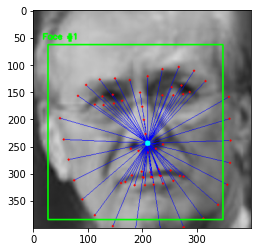

[[0. 0. 0. 0. 1. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0.]]
dataset/mux/happiness/Vicente_Fernandez_0005.jpg


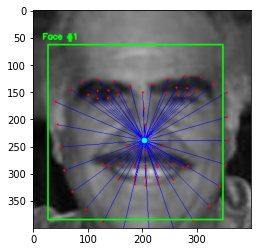

[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/John_Allen_Muhammad_0005.jpg


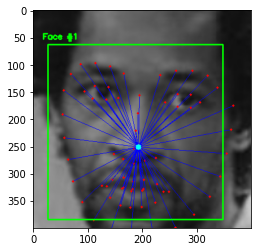

[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/Spencer_Abraham_0011.jpg


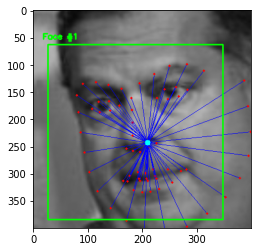

[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/Mike_Eskew_0001.jpg


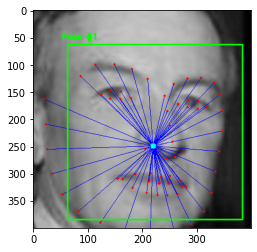

[[0. 0. 0. 0. 1. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/John_Duprey_0001.jpg


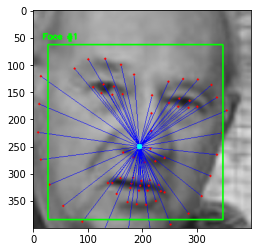

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.5781973e-23 0.0000000e+00 1.0000000e+00]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/neutral/Nate_Huffman_0001.jpg


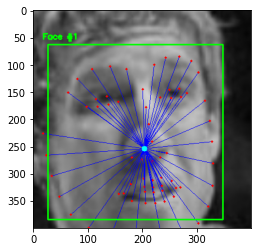

[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0.]]
dataset/mux/happiness/Koji_Uehara_0001.jpg


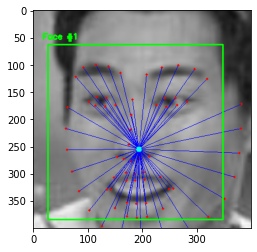

[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0.]]
dataset/mux/happiness/Constance_Marie_0001.jpg


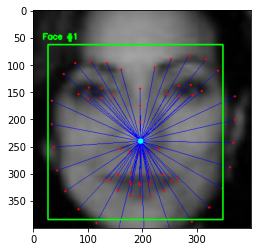

[[0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
dataset/mux/happiness/Guy_Verhofstadt_0001.jpg


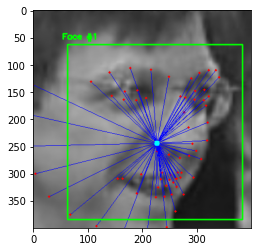

In [84]:
import random

# get all image filenames
image_filenames = []
dataset = dataset2
for root, dirs, files in os.walk(data_path + dataset + '/'):
    dir = os.path.basename(root)
    for file in files:
        image_filenames += [data_path + dataset + '/' + dir + '/' + file]
        
rand_images = random.sample(image_filenames, 10) # get random images

# load models
# cnn1 = load_model(model_path+'emotion-cnn1.hd5')
# cnn3 = load_model(model_path+'emotion-cnn3.hd5')
# svm1 = pickle.load(open(model_path+'emotion-svm1', 'rb'))
# svm2 = pickle.load(open(model_path+'emotion-svm2', 'rb')) 
cnnA = load_model(model_path+'emotion-cnnA.hd5')
cnnB = load_model(model_path+'emotion-cnnB.hd5')

for path in rand_images:
    vectors, coords = [], []
    classes = {}
    
    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape) 

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)

        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction
            coords.append([x-cog[0], y-cog[1]])

        cv2.circle(image, cog, 5, (0,255,255), -1)
        
        (x,y,w,h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        
        # model inputs
        ## vectors & coords
        vectors = np.array(vectors)
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
        vectors = vectors[:,0] * vectors[:,1]
        coords = (np.array(coords) * scale_factor).reshape(-1) # 1D array
        
        svm_vec_input = vectors.reshape(1,-1)
        cnn_vec_input = vectors.reshape(1, len(vectors), 1)
        svm_both_input = np.r_[vectors, coords].reshape(1,-1)
        cnn_both_input = np.r_[vectors, coords].reshape(1, len(vectors)+len(coords), 1)
#         print(svm_input.shape, cnn_input.shape)
        
        ## image graylevels
        cnn_px_input = image[y:y+h, x:x+w] # crop to face
        cnn_px_input = cv2.cvtColor(cnn_px_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
        cnn_px_input = cv2.equalizeHist(cnn_px_input) # equalize histogram
        cnn_px_input = imutils.resize(cnn_px_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
        cnn_px_input = np.expand_dims(cnn_px_input[:dim,:dim], axis=0) # shape=(1,dim,dim)
    
        # prediction
#         classes['CNN3'] = emotion_classes[np.argmax(cnn3.predict(cnn_both_input))]
#         classes['SVM2'] = emotion_classes[svm2.predict(svm_both_input)[0]]
#         classes['CNNA'] = emotion_classes[np.argmax(cnnA.predict(cnn_px_input))]
        i = 1
        for k,v in classes.items():
            print(k,v)
#             cv2.putText(image, '%s: %s' % (k,v), (x-20,y+h+20*i),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            i += 1
        print(cnnA.predict(cnn_px_input))
        print(cnnB.predict(cnn_px_input))
    
    print(path)
    plt.imshow(image) # adapted for jupyter
    plt.show()

## Just in case

In [ ]:
        # Akmadan's model
#         #1st CNN layer
#         model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout(0.25))

#         #2nd CNN layer
#         model.add(Conv2D(128,(5,5),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #3rd CNN layer
#         model.add(Conv2D(512,(3,3),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #4th CNN layer
#         model.add(Conv2D(512,(3,3), padding='same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Flatten())

#         #Fully connected 1st layer
#         model.add(Dense(256))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))

#         # Fully connected layer 2nd layer
#         model.add(Dense(512))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))